# Проект: классификация

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [151]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

In [152]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
df.info()

# 25

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


### Задание 2

In [153]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df['job'].unique()

# unknown

array(['admin.', 'technician', 'services', 'management', 'retired',
       'blue-collar', 'unemployed', 'entrepreneur', 'housemaid',
       'unknown', 'self-employed', 'student'], dtype=object)

### Задание 3

In [154]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance'] = df['balance'].replace('\$','', regex=True).replace(" ",'', regex=True).replace(',','.', regex=True).astype(float)
df['balance'].mean()

1529.1290293615875

### Задание 4

In [155]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
val = df['balance'].median()
df['balance'] = df['balance'].fillna(val)
df['balance'].mean()

1526.9360329690019

### Задание 5

In [179]:
data= df.copy()

mode_job = data['job'].mode()[0]
mask = data['job'] == 'unknown'

data.loc[(data['job'] == 'unknown'), 'job'] = mode_job


66       management
668      management
861      management
1075     management
1091     management
            ...    
9845     management
9976     management
10570    management
10660    management
10805    management
Name: job, Length: 70, dtype: object

In [181]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
mode_job = df['job'].mode()[0]
mask = df['job'] == 'unknown'
df.loc[(df['job'] == 'unknown'), 'job'] = mode_job

mode_edu = df['education'].mode()[0]
mask = df['education'] == 'unknown'
df.loc[(df['education'] == 'unknown'), 'education'] = mode_edu

In [182]:
# После замены пропусков рассчитайте средний баланс для клиентов с самой популярной работой и 
# самым популярным уровнем образования (т. е. для тех, у кого одновременно самая популярная работа и самое популярное образование). 
# Ответ округлите до трёх знаков после точки-разделителя.
mask = (df['job'] == mode_job) & (df['education'] == mode_edu)
df[mask]['balance'].mean()

1598.8829787234042

### Задание 6

In [185]:
# удалите все выбросы для признака balance
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x<=lower_bound) | (x >= upper_bound)]
    cleaned = data[(x>=lower_bound) & (x <= upper_bound)]
    return outliers, cleaned


outliers, cleaned = outliers_iqr(df, 'balance')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу Тьюки: 1058
Результирующее число записей: 10105


## Часть 2:  Разведывательный анализ

### Задание 1

no     5424
yes    4681
Name: deposit, dtype: int64

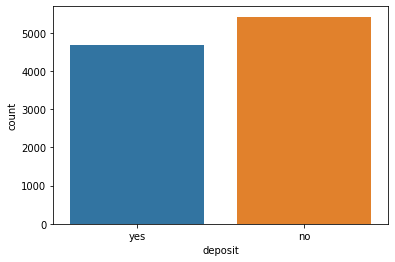

In [189]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
display(cleaned['deposit'].value_counts())
sns.countplot(data=cleaned, x='deposit');

### Задания 2 и 3

In [190]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
cleaned.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


### Задания 4 и 5

In [191]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты
cleaned.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


### Задание 6

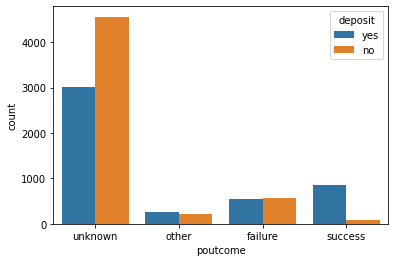

In [195]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
sns.countplot(data=cleaned, x='poutcome', hue='deposit');

### Задание 7

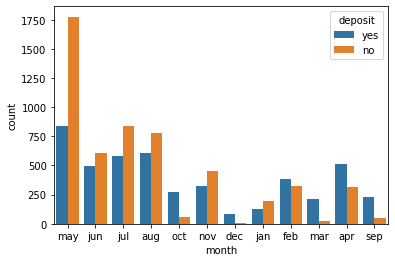

In [197]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
sns.countplot(data=cleaned, x='month', hue='deposit');

### Задание 8

<AxesSubplot:xlabel='age_group', ylabel='count'>

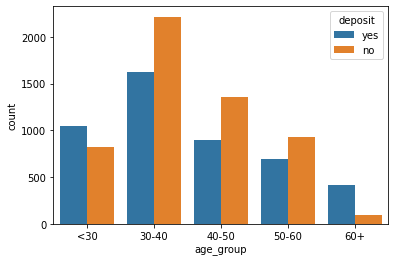

In [198]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения

# '<30';
# '30-40';
# '40-50';
# '50-60';
# '60+'.

# Для создания категорий используем метод cut()

cleaned['age_group'] = pd.cut(cleaned.age, [0,30,40,50,60,9999], labels = ['<30','30-40','40-50','50-60','60+'])
sns.countplot(x="age_group", hue="deposit", data=cleaned)

### Задания 9 и 10

<AxesSubplot:xlabel='count', ylabel='marital'>

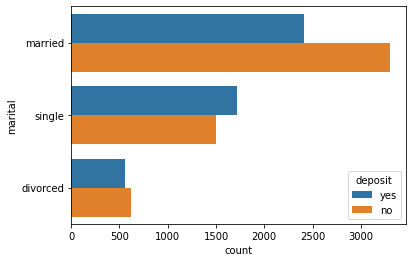

In [199]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
sns.countplot(y='marital', hue='deposit', data=cleaned)

<AxesSubplot:xlabel='count', ylabel='education'>

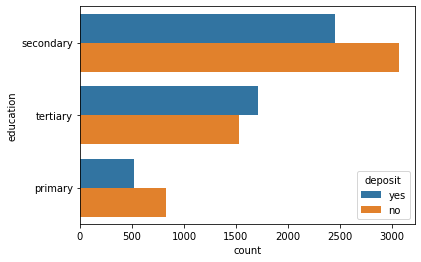

In [200]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
sns.countplot(y='education', hue='deposit', data=cleaned)

<AxesSubplot:xlabel='count', ylabel='job'>

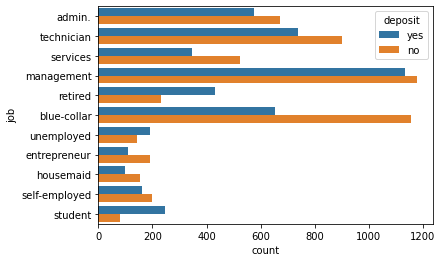

In [201]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
sns.countplot(y='job', hue='deposit', data=cleaned)

### Задание 11

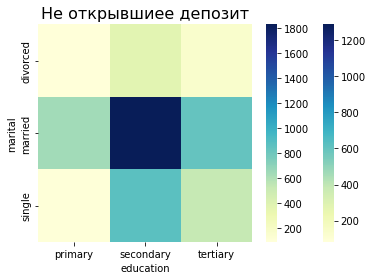

In [218]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
mask_yes = cleaned['deposit'] == 'yes'
data_yes = cleaned[mask_yes]

mask_no = cleaned['deposit'] == 'no'
data_no = cleaned[mask_no]

cross_yes = pd.crosstab(
    data_yes.marital,
    data_yes.education
)

cross_no = pd.crosstab(
    data_no.marital,
    data_no.education
)

heatmap_yes = sns.heatmap(data=cross_yes, cmap='YlGnBu')
heatmap_yes.set_title('Открывшиее депозит', fontsize=16);

heatmap_no = sns.heatmap(data=cross_no, cmap='YlGnBu')
heatmap_no.set_title('Не открывшиее депозит', fontsize=16);

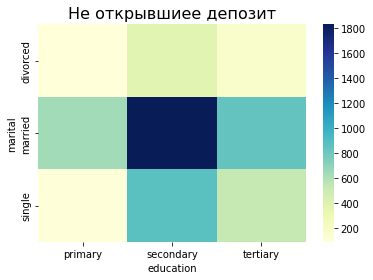

In [219]:
heatmap_no = sns.heatmap(data=cross_no, cmap='YlGnBu')
heatmap_no.set_title('Не открывшиее депозит', fontsize=16);

## Часть 3: преобразование данных

In [249]:
data = df.copy()
df = cleaned.copy()

### Задание 1

In [251]:
# преобразуйте уровни образования
# Создание экземпляра класса LabelEncoder()
lab_enc = LabelEncoder()

# Кодирование признака
df['education'] = lab_enc.fit_transform(df['education'])
df['education'].sum()

11995

In [252]:
# Кодирование признака
df['age_group'] = lab_enc.fit_transform(df['age_group'])

### Задания 2 и 3

In [253]:
# преобразуйте бинарные переменные в представление из нулей и единиц
df['deposit'] = df['deposit'].apply(lambda x: 1 if x=='yes' else 0)
df['default'] = df['default'].apply(lambda x: 1 if x=='yes' else 0)
df['housing'] = df['housing'].apply(lambda x: 1 if x=='yes' else 0)
df['loan'] = df['loan'].apply(lambda x: 1 if x=='yes' else 0)

In [243]:
df['deposit'].std()

0.4986712532452124

In [245]:
# 4.3
# Вычислите среднее арифметическое для каждой из получившихся переменных, 
# сложите три результата и в качестве ответа впишите итог, округлив его до трёх знаков после точки-разделителя.

df['default'].mean() + df['housing'].mean() + df['loan'].mean()

0.6354280059376547

### Задание 4

In [265]:
# создайте дамми-переменные
one_hot = pd.get_dummies(df, columns=['job','marital','contact', 'month', 'poutcome'])
one_hot


,age,education,default,balance,housing,loan,day,duration,campaign,pdays,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,59,1,0,2343.0,1,0,5,1042,1,-1,...,0,0,1,0,0,0,0,0,0,1
1,56,1,0,45.0,0,0,5,1467,1,-1,...,0,0,1,0,0,0,0,0,0,1
2,41,1,0,1270.0,1,0,5,1389,1,-1,...,0,0,1,0,0,0,0,0,0,1
3,55,1,0,2476.0,1,0,5,579,1,-1,...,0,0,1,0,0,0,0,0,0,1
4,54,2,0,184.0,0,0,5,673,2,-1,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,0,0,1.0,1,0,20,257,1,-1,...,0,0,0,0,0,0,0,0,0,1
11158,39,1,0,733.0,0,0,16,83,4,-1,...,1,0,0,0,0,0,0,0,0,1
11159,32,1,0,29.0,0,0,19,156,2,-1,...,0,0,0,0,0,0,0,0,0,1
11160,43,1,0,0.0,0,1,8,9,2,172,...,0,0,1,0,0,0,1,0,0,0


### Задания 5 и 6

,index,deposit
11,deposit,1.000000
7,duration,0.457818
44,poutcome_success,0.288491
27,contact_cellular,0.223944
9,pdays,0.147917


<AxesSubplot:>

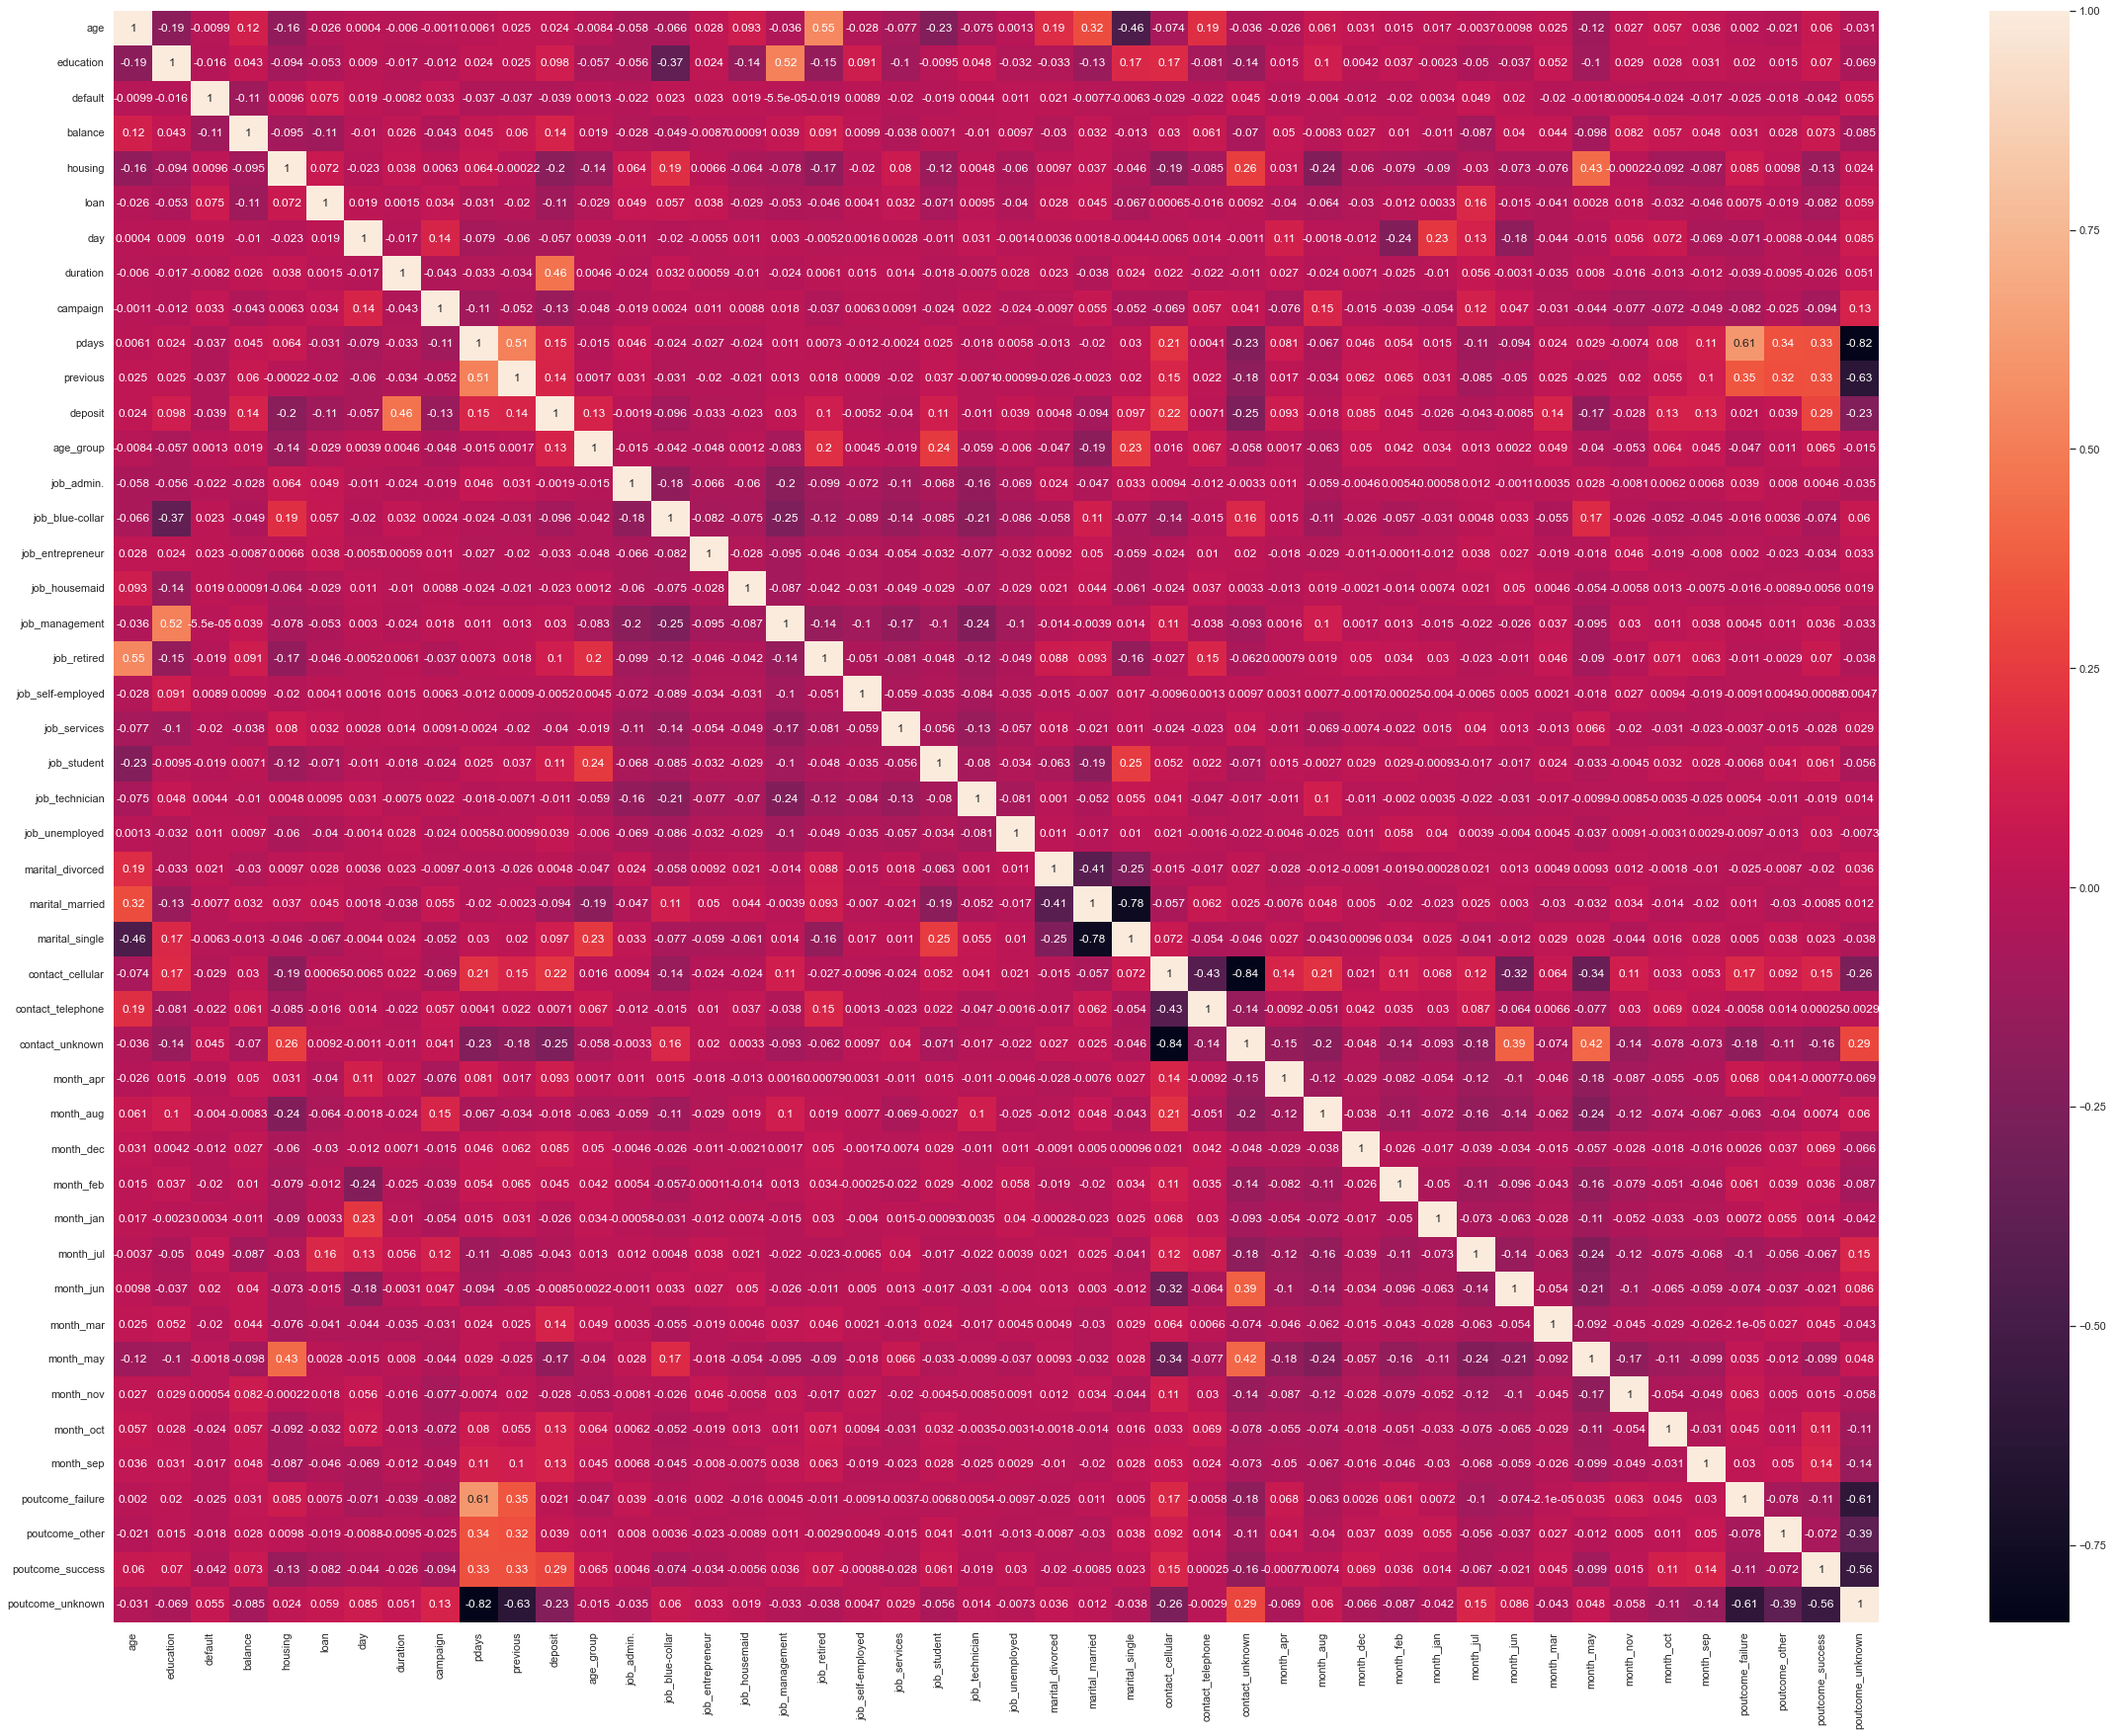

In [271]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
df = one_hot.copy()
corr = df.corr()

new_corr = corr['deposit'].reset_index()
sort_corr = new_corr.sort_values('deposit', ascending=False)
display(sort_corr.head())
sns.set(rc = {'figure.figsize':(40,30)})
sns.heatmap(df.corr(), annot=True)

### Задания 7 и 8

In [275]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [277]:
# рассчитайте необходимые показатели
display(X_test.shape)
display(y_test.mean())

(3335, 45)

0.46326836581709147

### Задание 9

In [281]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
from sklearn.feature_selection import SelectKBest, f_classif
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)
 
columns = selector.get_feature_names_out()
columns

array(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_group', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

In [283]:
X_train = X_train[columns]
X_test = X_test[columns]

### Задание 10

In [284]:
# нормализуйте данные с помощью minmaxsxaler
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)                           # fit() только на train данных
X_train_scaled = scaler.transform(X_train)    # fransform() на train данных
X_test_scaled = scaler.transform(X_test)      # fransform() на test данных

print(X_test_scaled[:, 0].mean())  # для признака balance, обратите внимание именно на столбец

0.46823674223097866


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [288]:
# обучите логистическую регрессию и рассчитайте метрики качества
log_reg = linear_model.LogisticRegression(
    solver='sag', 
    random_state=42, 
    max_iter=1000 )

log_reg.fit(X_train_scaled, y_train)
y_pred_train = log_reg.predict(X_train_scaled)
display(metrics.accuracy_score(y_train, y_pred_train))
y_pred = log_reg.predict(X_test_scaled)
display(metrics.accuracy_score(y_test, y_pred))

0.823781388478582

0.8083958020989506

### Задания 2,3,4

In [303]:
# обучите решающие деревья, настройте максимальную глубину
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
    max_depth = 6
)

dt.fit(X_train_scaled, y_train)
y_pred_train = dt.predict(X_train_scaled)
display(metrics.accuracy_score(y_train, y_pred_train))
y_pred_test = dt.predict(X_test_scaled)
display(metrics.accuracy_score(y_test, y_pred_test))

0.8180206794682422

0.8065967016491754

### Задание 5

In [310]:
from sklearn.model_selection import GridSearchCV

parameters =  {'min_samples_split': [2, 5, 7, 10], 'max_depth':[3,5,7]}

model_cv = GridSearchCV(tree.DecisionTreeClassifier(random_state=42), 
                        parameters,
                        cv=3, scoring=('f1'), 
                        return_train_score=True)

model_cv.fit(X_train_scaled, y_train)

y_pred_train = model_cv.predict(X_train_scaled)
display(metrics.f1_score(y_train, y_pred_train))
y_pred_test = model_cv.predict(X_test_scaled)
display(metrics.f1_score(y_test, y_pred_test))
print("Наилучшие значения гиперпараметров: {}".format(model_cv.best_params_))


0.8258105530832803

0.800763844684914

Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 2}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [316]:
# обучите на ваших данных случайный лес
rf = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42
)
#Обучаем модель
rf.fit(X_train_scaled, y_train)

y_pred_train = rf.predict(X_train_scaled)
#display(metrics.classification_report(y_train, y_pred_train))
y_pred_test = rf.predict(X_test_scaled)
display(metrics.accuracy_score(y_test, y_pred_test))
display(round(metrics.recall_score(y_test, y_pred_test),2))

0.8266866566716642

0.83

### Задания 2 и 3

In [319]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
gb = ensemble.GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)
gb.fit(X_train_scaled, y_train)

y_pred_train = gb.predict(X_train_scaled)
#display(metrics.classification_report(y_train, y_pred_train))
y_pred_test = gb.predict(X_test_scaled)
display(metrics.accuracy_score(y_test, y_pred_test))
display(round(metrics.f1_score(y_test, y_pred_test),2))

0.8263868065967016

0.82

### Задание 4

In [320]:
# объедините уже известные вам алгоритмы с помощью стекинга 
estimators = [
    ('dt', tree.DecisionTreeClassifier(
        criterion='entropy',
        min_samples_leaf=5,
        max_depth=6,
        random_state=42
        )
    ),
    ('log_reg', linear_model.LogisticRegression(
        solver='sag',
        random_state=42 
        )
    ),
    ('gb', ensemble.GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=5,
        random_state=42
        )
    )
]

stack = ensemble.StackingClassifier(
    estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42)
)
stack.fit(X_train_scaled, y_train)

y_pred_test = stack.predict(X_test_scaled)

display(round(metrics.precision_score(y_test, y_pred_test),2))

0.81

### Задание 5

In [326]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
from sklearn.feature_selection import RFE

estimator = gb  # ранее использованный алгоритм
selector = RFE(estimator, n_features_to_select=3, step=1)
selector = selector.fit(X_train_scaled, y_train)

print(selector.get_feature_names_out())
print(X_train.columns)
print(selector.ranking_)

['x0' 'x2' 'x13']
Index(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_group', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')
[ 1  4  1  8  3 11  5 12  2  6  9  7 10  1 13]


### Задания 6,7,8

In [327]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
import optuna

def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score

# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42 )
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))


[I 2022-12-21 13:18:17,266] A new study created in memory with name: RandomForestClassifier
[I 2022-12-21 13:18:17,775] Trial 0 finished with value: 0.8536393648797359 and parameters: {'n_estimators': 162, 'max_depth': 10, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8536393648797359.
[I 2022-12-21 13:18:18,278] Trial 1 finished with value: 0.8628001247271593 and parameters: {'n_estimators': 156, 'max_depth': 17, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.8628001247271593.
[I 2022-12-21 13:18:18,687] Trial 2 finished with value: 0.9017758918749017 and parameters: {'n_estimators': 112, 'max_depth': 16, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.9017758918749017.
[I 2022-12-21 13:18:19,306] Trial 3 finished with value: 0.8927454659161976 and parameters: {'n_estimators': 177, 'max_depth': 21, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.9017758918749017.
[I 2022-12-21 13:18:19,768] Trial 4 finished with value: 0.8541114058355437 and parameters: {'n_

Наилучшие значения гиперпараметров {'n_estimators': 131, 'max_depth': 30, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.92
accuracy на тестовом наборе: 0.83
f1_score на тестовом наборе: 0.82
